In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures # Added PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report

In [ ]:
df = pd.read_csv("/content/Titanic-Dataset.csv")

df


PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  \
0                              Braund, Mr. Owen Harris    male  22.0   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2                               Heikkinen, Miss. Laina  female  26.0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4                             Allen, Mr. William Henry    male  35.0   
..                                                 ...     ...   ...   
886                              Montvila, Rev. Juozas    male  27.0   
887                       Graham, Miss. Margaret Edith  female  19.0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
889                              Behr, Mr. Karl Howell    male  26.0   
890                                Dooley, Mr. Patrick    male  32.0   

               Ticket     Fare Embarked  
0           A/5 21171   7.2500        S  
1            PC 17599  71.2833        C  
2    STON/O2. 3101282   7.9250        S  
3              113803  53.1000        S  
4              373450   8.0500        S  
..                ...      ...      ...  
886            211536  13.0000        S  
887            112053  30.0000        S  
888        W./C. 6607  23.4500        S  
889            111369  30.0000        C  
890            370376   7.7500        Q  

[891 rows x 9 columns]

In [ ]:
# Check for any missing values
print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
Ticket           0
Fare             0
Embarked         2
dtype: int64


In [ ]:
# Impute missing 'Fare' values with the median
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Impute missing 'Age' values with the median
df['Age'].fillna(df['Age'].median(), inplace=True)

# One-hot encode 'Sex' and 'Embarked'
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Select numerical columns for polynomial features
num_cols = ['Pclass', 'Age', 'Fare']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print(df[num_cols].isnull().sum())

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
features = ['Pclass', 'Age', 'Fare']
X_poly = poly.fit_transform(df[features])
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features))


# Merge with other features
X = pd.concat([X_poly_df, df[['Sex_male', 'Embarked_Q', 'Embarked_S']].reset_index(drop=True)], axis=1)
y = df['Survived']

Pclass    0
Age       0
Fare      0
dtype: int64


/tmp/ipython-input-14-3092928551.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Fare'].fillna(df['Fare'].median(), inplace=True)
/tmp/ipython-input-14-3092928551.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    start = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start
    y_pred = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        y_pred_class = model.predict(X_test)
    else:
        y_pred_class = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} -- Accuracy: {acc:.4f}, F1: {f1:.4f}, R²: {r2:.4f}, RMSE: {rmse:.4f}, Time: {training_time:.2f}s")
    return {
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "R2": r2,
        "RMSE": rmse,
        "Time": training_time
    }


In [ ]:
results = []

# Linear Regression (treat as regression problem)
lin_reg = LinearRegression()
results.append(evaluate_model(lin_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression"))

# Ridge
ridge = Ridge(alpha=1.0)
results.append(evaluate_model(ridge, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression"))

# Lasso
lasso = Lasso(alpha=0.01)
results.append(evaluate_model(lasso, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression"))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
results.append(evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"))

# SGD Classifier
sgd = SGDClassifier(loss='log_loss', max_iter=1000)
results.append(evaluate_model(sgd, X_train_scaled, X_test_scaled, y_train, y_test, "SGD Classifier"))


Linear Regression -- Accuracy: 0.7933, F1: 0.7448, R²: 0.4255, RMSE: 0.3733, Time: 0.03s
Ridge Regression -- Accuracy: 0.7989, F1: 0.7500, R²: 0.4252, RMSE: 0.3733, Time: 0.01s
Lasso Regression -- Accuracy: 0.7877, F1: 0.7324, R²: 0.4210, RMSE: 0.3747, Time: 0.00s
Logistic Regression -- Accuracy: 0.8045, F1: 0.7552, R²: 0.1937, RMSE: 0.4422, Time: 0.11s
SGD Classifier -- Accuracy: 0.7318, F1: 0.7209, R²: -0.1058, RMSE: 0.5178, Time: 0.02s


In [ ]:
def plot_learning(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning(log_reg, X_train_scaled, y_train, "Logistic Regression Learning Curve")


In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

grid_ridge = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(X_train_scaled, y_train)

print("Best Ridge Alpha:", grid_ridge.best_params_)


Best Ridge Alpha: {'alpha': 10}


In [ ]:
results_df = pd.DataFrame(results)
print(results_df[['Model', 'Accuracy', 'F1-Score', 'R2', 'RMSE', 'Time']])


                 Model  Accuracy  F1-Score        R2      RMSE      Time
0    Linear Regression  0.793296  0.744828  0.425491  0.373255  0.033341
1     Ridge Regression  0.798883  0.750000  0.425240  0.373337  0.009122
2     Lasso Regression  0.787709  0.732394  0.421025  0.374703  0.002179
3  Logistic Regression  0.804469  0.755245  0.193694  0.442189  0.109041
4       SGD Classifier  0.731844  0.720930 -0.105792  0.517838  0.016430


/tmp/ipython-input-24-1939958881.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette='coolwarm')


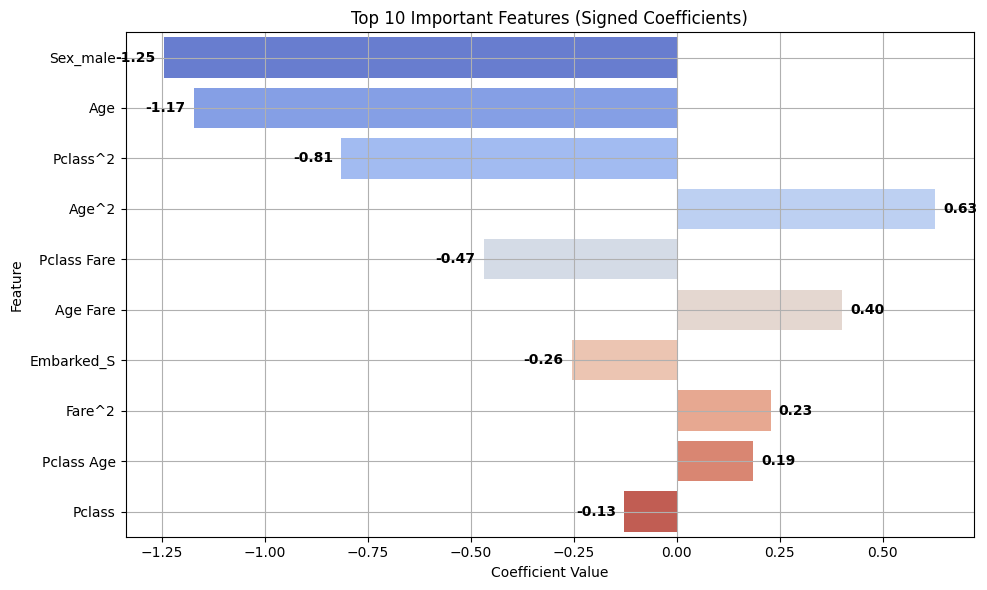

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# For Logistic Regression
importance = log_reg.coef_[0]
feature_names = X.columns

# Create DataFrame of feature importances
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort by absolute value of importance and keep top 10
top_features = feature_imp_df.reindex(feature_imp_df['Importance'].abs().sort_values(ascending=False).index).head(10)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette='coolwarm')

# Add labels for each bar
for i, (value, feature) in enumerate(zip(top_features['Importance'], top_features['Feature'])):
    ax.text(
        value + 0.02 if value > 0 else value - 0.02,
        i,
        f"{value:.2f}",
        color='black',
        ha='left' if value > 0 else 'right',
        va='center',
        fontweight='bold'
    )

plt.title("Top 10 Important Features (Signed Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


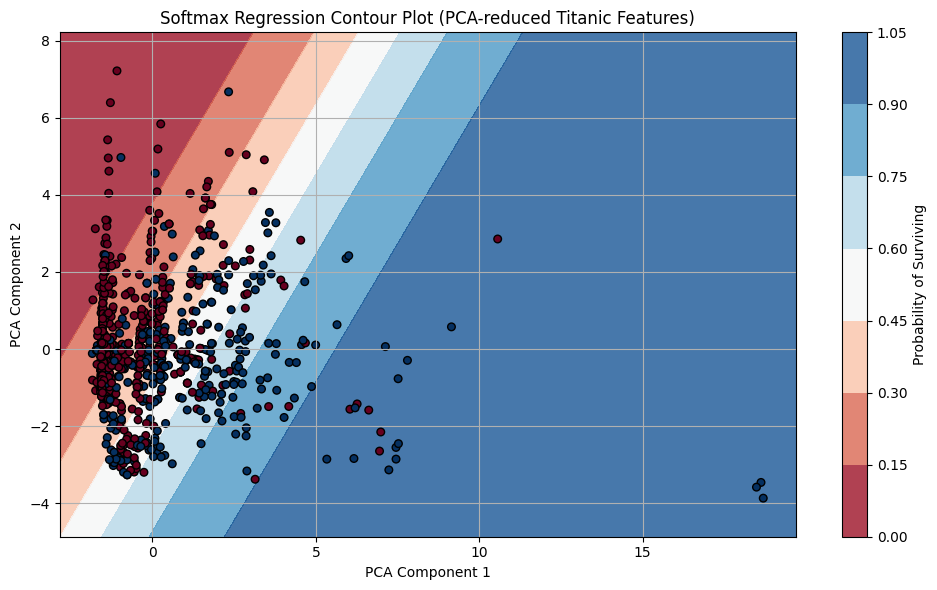

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Step 1: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Fit Softmax Regression (Logistic Regression for binary with "multinomial" to get softmax style)
softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
softmax_clf.fit(X_pca, y)

# Step 4: Create meshgrid for PCA space
x0, x1 = np.meshgrid(
    np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
    np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500)
)
X_grid = np.c_[x0.ravel(), x1.ravel()]

# Step 5: Predict probabilities on grid
y_proba = softmax_clf.predict_proba(X_grid)[:, 1].reshape(x0.shape)

# Step 6: Plot decision contour
plt.figure(figsize=(10, 6))
contour = plt.contourf(x0, x1, y_proba, alpha=0.8, cmap="RdBu")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="RdBu", edgecolor='k', s=30)
plt.colorbar(contour, label="Probability of Surviving")
plt.title("Softmax Regression Contour Plot (PCA-reduced Titanic Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
